In [1]:
!pip install attacut
!pip install kaggle
!pip install pythainlp
!pip install pytorch-lightning
!pip install datasets
!pip install torch
!pip install wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np # linear algebra
import pandas as pd
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
import attacut
import pythainlp
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from torch.utils.data import Dataset
from IPython.display import display
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [3]:
import os
import wandb

# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Login to wandb
wandb.login(key="65e03aafcd9e07b23dd4cf63309c4f2c353f1623")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: crimsonf09 (crimsonf09-chulalongkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
run = wandb.init(
    # entity="Ella",
    # # Set the wandb project where this run will be logged.
    project="Ella",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "BERT",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

In [5]:
type = ['Paper Work',
'Summary',
'Paraphrase',
'Simulation Role Play as a Character',
'Reasoning',
'Trending',
'Caption Generation',
'General',
'Marketing Planning']

In [6]:
def cleanData(pathCSV,filename):    
    data = []
    with open(pathCSV, "r", encoding="utf-8") as file:
        get_cols = False
        current_type = None
        current_context = None
        current_sentence = ""
    
        for line in file:
            line = line.strip()
            if not get_cols:
                cols = line.split(",")
                get_cols = True
                continue
    
            parts = line.split(",", 2)  # split into 3 parts only
    
            if len(parts) == 3:
                # Save the previous sentence before starting a new row
                if current_type is not None:
                    data.append([current_type, current_context, current_sentence.strip()])
                current_type = parts[0]
                current_context = parts[1]
                current_sentence = parts[2]
            else:
                # Continuation of sentence
                current_sentence += "\n" + line
    
        # Add the last row
        if current_type is not None:
            data.append([current_type, current_context, current_sentence.strip()])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=["type", "contextLevel", "sentence"])
    
    # Save as CSV
    df.to_csv('/kaggle/working/'+filename+'.csv', index=False)
    
    print("done " + filename)

In [7]:
cleanData('/kaggle/input/generated-data/generated_data.csv','cleaned_generated_data')
cleanData('/kaggle/input/generated-thai-dataset/generated_thai_data.csv','cleaned_generated_thai_data')

done cleaned_generated_data
done cleaned_generated_thai_data


In [8]:
eng_generated_data = pd.read_csv("/kaggle/working/cleaned_generated_data.csv")
thai_generated_data = pd.read_csv("/kaggle/working/cleaned_generated_thai_data.csv")
thai_hard_generated_data = pd.read_csv("/kaggle/input/generated-thai-hard-data-csv/generated_thai_hard_data.csv")
new_thai = pd.read_csv("/kaggle/input/new-thai-generated/generated_thai.csv")

In [9]:
print(new_thai.head())

               type difficulty  \
0  research_insight       easy   
1  research_insight       easy   
2  research_insight       easy   
3  research_insight       easy   
4  research_insight       easy   

                                            sentence  
0            ช่วยวิเคราะห์ข้อมูลยอดขายไตรมาสนี้หน่อย  
1           หาข้อมูล market share ของคู่แข่งให้หน่อย  
2  ต้องการ insight เกี่ยวกับพฤติกรรมลูกค้าในช่วง ...  
3  วิเคราะห์ trend การใช้ social media ของกลุ่มเป...  
4  ช่วยดู data customer satisfaction จากแบบสำรวจล...  


In [10]:
print(eng_generated_data['sentence'].isnull().sum())

0


In [11]:
# print(thai_generated_data['type'].value_counts())
# print(eng_generated_data['type'].value_counts())
print(new_thai['type'].value_counts())

type
research_insight            80
strategy_planning           80
goal_breakdown              80
creative_idea_generation    80
judgment_decision           80
judgment_hr_decision        80
idea_validation             80
paraphrase                  80
candidate_screening         80
Name: count, dtype: int64


In [12]:
# thai_df = pd.DataFrame(thai_generated_data)
# thai_hard_df = pd.DataFrame(thai_hard_generated_data)
# eng_df = pd.DataFrame(eng_generated_data)
thai_df = pd.DataFrame(new_thai)

In [13]:
# type = ['Paper Work',
# 'Summary',
# 'Paraphrase',
# 'Simulation Role Play as a Character',
# 'Reasoning',
# 'Trending',
# 'Caption Generation',
# 'General',
# 'Marketing Planning']
type = [
    "research_insight",
    "strategy_planning",
    "goal_breakdown",
    "creative_idea_generation",
    "judgment_decision",
    "judgment_hr_decision",
    "idea_validation",
    "paraphrase",
    "candidate_screening"
]

type2ind={}
ind2type={}
ind = 0
for i in type:
    type2ind[i] = ind
    ind2type[ind] = i
    ind += 1
context_level = thai_df['difficulty'].unique()
print(context_level)
context2level = {}
level2context = {}
ind = 0
for i in context_level:
    context2level[i] = ind
    level2context[ind] = i
    ind+=1

['easy' 'medium' 'hard']


In [14]:
thai_df['type'] = thai_df['type'].map(type2ind)
thai_df['contextLevel'] = thai_df['difficulty'].map(context2level)
# thai_hard_df['type'] = thai_hard_df['type'].map(type2ind)
# thai_hard_df['contextLevel'] = thai_hard_df['contextLevel'].map(context2level)
# eng_df['type'] = eng_df['type'].map(type2ind)
# eng_df['contextLevel'] = eng_df['contextLevel'].map(context2level)

In [15]:
thai_df = thai_df.drop(columns=['difficulty'])


In [16]:
thai_df

,type,sentence,contextLevel
0,0,ช่วยวิเคราะห์ข้อมูลยอดขายไตรมาสนี้หน่อย,0
1,0,หาข้อมูล market share ของคู่แข่งให้หน่อย,0
2,0,ต้องการ insight เกี่ยวกับพฤติกรรมลูกค้าในช่วง ...,0
3,0,วิเคราะห์ trend การใช้ social media ของกลุ่มเป...,0
4,0,ช่วยดู data customer satisfaction จากแบบสำรวจล...,0
...,...,...,...
715,8,ต้องการ assessment ของ longevity economy leade...,2
716,8,ช่วยดู decentralized autonomous organization l...,2
717,8,ประเมิน consciousness technology leader candid...,2
718,8,ต้องการ comprehensive review ของ post-scarcity...,2


In [17]:

def train_val_test_split(df):
    # First split: Train 60%, Temp 40%
    train_df, temp_df = train_test_split(
        df,
        train_size=0.6,
        random_state=99,
        stratify=df[['type', 'contextLevel']]
    )

    # Second split: Val 20%, Test 20% (half of temp)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=0.5,
        random_state=99,
        stratify=temp_df[['type', 'contextLevel']]
    )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [18]:
thai_train_df,thai_val_df,thai_test_df = train_val_test_split(thai_df)
# eng_train_df,eng_val_df,eng_test_df = train_val_test_split(eng_df)
# thai_hard_train_df,thai_hard_val_df,thai_hard_test_df = train_val_test_split(thai_hard_df)
# train_df = pd.concat([thai_train_df,eng_train_df,thai_hard_train_df])
# val_df = pd.concat([thai_val_df,eng_val_df,thai_hard_val_df])
# test_df = pd.concat([thai_test_df,eng_test_df,thai_hard_test_df])
# test = thai_hard_test_df
train_df = thai_train_df
val_df = thai_val_df
test_df = thai_test_df

In [19]:
from difflib import SequenceMatcher

def is_similar(a, b, threshold=0.95):
    return SequenceMatcher(None, a, b).ratio() > threshold

suspicious = []
for val_sentence in val_df['sentence']:
    for train_sentence in train_df['sentence']:
        if is_similar(val_sentence, train_sentence):
            suspicious.append((val_sentence, train_sentence))
            break  # Stop early once one match is found

print(f"Found {len(suspicious)} highly similar val samples in train set")

Found 0 highly similar val samples in train set


In [20]:
train_df['type'].value_counts()

type
6    48
1    48
3    48
2    48
8    48
4    48
7    48
0    48
5    48
Name: count, dtype: int64

In [21]:
print(torch.cuda.is_available())

True


In [22]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer

checkpoint = "clicknext/phayathaibert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenizer_dataset(dataset):
    encoded = tokenizer(
        dataset['sentence'],
        padding='max_length',
        max_length=256,#128
        truncation=True,
    )
    encoded['labels'] = dataset['type']
    return encoded
train_dataset = Dataset.from_pandas(train_df[['type','sentence']])
eval_dataset = Dataset.from_pandas(val_df[['type','sentence']])

print(train_dataset[0])

# tokenize
tokenized_train_dataset = train_dataset.map(tokenizer_dataset,batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenizer_dataset,batched=True)

tokenized_train_dataset.set_format('torch')
tokenized_eval_dataset.set_format('torch')
# # dataloader
train_loader = DataLoader(tokenized_train_dataset,batch_size=64, shuffle=True)
eval_loader = DataLoader(tokenized_eval_dataset,batch_size=64, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

{'type': 6, 'sentence': 'ต้องการ validate การเพิ่ม delivery service'}


Map:   0%|          | 0/432 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

In [23]:
class HuggingFaceDataset(torch.utils.data.Dataset):
    def __init__(self,hf_dataset):
        self.dataset = hf_dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        item = self.dataset[idx]
        input_ids = item['input_ids'].clone().detach().long()
        attention_mask = item['attention_mask'].clone().detach().long()
        labels = item['labels'].clone().detach().long()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

In [24]:
train_dataset = HuggingFaceDataset(tokenized_train_dataset)
eval_dataset = HuggingFaceDataset(tokenized_eval_dataset)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

In [25]:
train_dataset.__getitem__(1)

{'input_ids': tensor([     5,     10,  19230, 112535, 172916,  26290,     10,   2033,  61936,
             10,     31, 169718,  49720,   9729,    489,   2969,  28758,  64163,
         121991,  32761,   2829,     14,  29816,   1276,  15843,     10, 221635,
             14, 143762,  75713,     14,  37929,     10, 151582,   4249,  68974,
            110,     14,  35277,  25299,  79567, 115801,     14,  29334,  69704,
           8403,  69836,   2829,     14,  62659,  56452,  58452,     14,    222,
          54577,  37435,   3769,  26256,  77194,  15261,     24, 122780, 153059,
          52511, 204866,    222,  25610,  93021,  31605, 226579,   6064,      6,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1

In [26]:
import torch
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import f1_score

class BertClassifier(pl.LightningModule):
    def __init__(self, model_name: str, num_labels: int = 9, learning_rate: float = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

        # Accumulators
        self.val_preds, self.val_labels = [], []
        self.test_preds, self.test_labels = [], []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        print(batch['labels'].dtype, batch['labels'].min(), batch['labels'].max())
        outputs = self(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        self.val_preds.extend(preds.cpu().tolist())
        self.val_labels.extend(batch["labels"].cpu().tolist())
        self.log("val_loss", outputs.loss, prog_bar=True)
        return outputs.loss

    def on_validation_epoch_end(self):
        f1 = f1_score(self.val_labels, self.val_preds, average="micro")
        self.log("val_f1", f1, prog_bar=True)
        self.val_preds.clear()
        self.val_labels.clear()

    def test_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        self.test_preds.extend(preds.cpu().tolist())
        self.test_labels.extend(batch["labels"].cpu().tolist())
        return outputs.loss

    def on_test_epoch_end(self):
        f1 = f1_score(self.test_labels, self.test_preds, average="micro")
        self.log("test_f1", f1)
        print(f"\n🔍 Test F1 Score (micro): {f1:.4f}")
        self.test_preds.clear()
        self.test_labels.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)


In [27]:
model = BertClassifier(model_name=checkpoint, num_labels=9) 

epoch = 4
wandb_logger = WandbLogger(
    project="bert-multiclass",     # Your project name in wandb
    name="bert-run-001",           # Optional run name
    log_model="all"                # Optionally save model checkpoints to wandb
)
trainer = pl.Trainer(
    max_epochs = epoch,
    accelerator = "gpu" if torch.cuda.is_available() else "cpu",
    devices = 1,
    # precision=16,   # optional
    logger=wandb_logger
)

trainer.fit(model, train_loader, val_loader)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

2025-07-17 09:53:24.481666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752746004.660915      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752746004.718527      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(1, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(7, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(7, device='cuda:0')
torch.int64 tensor(0, device='cuda:0') tensor(8, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

In [30]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer

# Assuming your model and tokenizer are already defined as follows:
model_name = "clicknext/phayathaibert"  # Change this to your model's name if necessary
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize device and model (your model already has this part)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def tokenize_test_dataset(dataset):
    encoded = tokenizer(
        dataset['sentence'],
        padding='max_length',
        max_length=256,#128
        truncation=True,
    )
    return encoded

# Assuming `test_df` is your test data frame containing 'comment' column.
test_dataset = Dataset.from_pandas(test_df)

# Apply the tokenizer to the dataset
test_dataset = test_dataset.map(tokenize_test_dataset, batched=True)

# Set the format to be suitable for PyTorch (with input_ids and attention_mask)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Prepare DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the model to evaluation mode
model.eval()

predictions = []

# Run inference
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)  # Apply softmax for multi-class classification
        
        # Get the predicted class (index of highest probability)
        preds = torch.argmax(probs, dim=-1)
        predictions.append(preds.cpu().numpy())  # Store predictions in CPU memory

# Concatenate all predictions into a single array
predicted_labels = np.concatenate(predictions, axis=0)

# Create a DataFrame to store predictions with a single column 'predicted_label'
preds_df = pd.DataFrame(predicted_labels, columns=["predicted_label"])

# Print out the predictions for the first 20 samples
for text, real_label,label in zip(test_df["sentence"],test_df['type'], predicted_labels):
    if (real_label != label):
        print(f"Text: {text}")
        print(f"True Label: {ind2type[real_label]}")
        print(f"Predicted Label: {ind2type[label]}")
        print("-" * 50)
        print("")


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Text: ต้องการกลยุทธ์การ optimize customer journey ข้าม multiple touchpoints และ channels
True Label: strategy_planning
Predicted Label: goal_breakdown
--------------------------------------------------

Text: ช่วยสร้าง action plan สำหรับการเพิ่ม customer satisfaction
True Label: goal_breakdown
Predicted Label: strategy_planning
--------------------------------------------------

Text: เลือกระหว่างการ promote diverse candidate เพื่อ DEI goals หรือ most qualified candidate ตาม traditional metrics
True Label: judgment_hr_decision
Predicted Label: judgment_decision
--------------------------------------------------

Text: ช่วยสร้างแนวคิด regenerative business ecosystem ที่ actively contribute ต่อ healing และ restoration ของ natural และ social systems โดย integrate regenerative practices เข้าใน every aspect ของ business operations พร้อมทั้งสร้าง positive impact measurement และ stakeholder engagement frameworks
True Label: creative_idea_generation
Predicted Label: strategy_planning
---------

In [31]:
predicted_labels

array([8, 4, 5, 4, 0, 4, 7, 2, 4, 8, 2, 1, 2, 4, 1, 6, 1, 4, 0, 0, 7, 6,
       8, 3, 1, 7, 0, 3, 2, 5, 5, 6, 4, 0, 1, 1, 3, 3, 3, 1, 3, 8, 2, 4,
       4, 8, 4, 0, 5, 8, 3, 1, 6, 0, 8, 4, 6, 3, 1, 0, 2, 1, 6, 2, 7, 5,
       7, 7, 0, 6, 1, 0, 4, 0, 8, 5, 7, 6, 0, 6, 7, 3, 0, 2, 8, 0, 5, 1,
       0, 7, 6, 7, 3, 5, 7, 0, 2, 1, 4, 6, 8, 2, 6, 7, 7, 5, 6, 8, 6, 7,
       7, 3, 4, 5, 3, 1, 6, 1, 3, 1, 4, 2, 5, 3, 2, 0, 1, 4, 3, 3, 7, 5,
       6, 5, 6, 6, 4, 8, 4, 2, 4, 6, 2, 2])

Accuracy: 0.8681
F1 Scores:
  Micro:    0.8681
  Macro:    0.8666
  Weighted: 0.8666

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.76      0.81      0.79        16
           2       0.80      0.75      0.77        16
           3       0.94      0.94      0.94        16
           4       0.74      0.88      0.80        16
           5       0.85      0.69      0.76        16
           6       0.84      1.00      0.91        16
           7       1.00      1.00      1.00        16
           8       1.00      0.75      0.86        16

    accuracy                           0.87       144
   macro avg       0.87      0.87      0.87       144
weighted avg       0.87      0.87      0.87       144



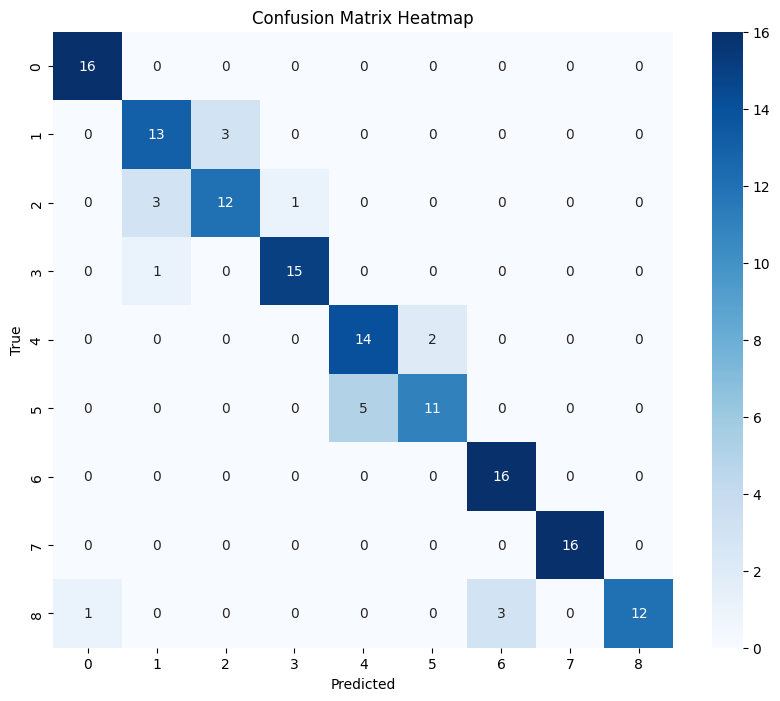

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Assuming these are already defined
# test_df = pd.DataFrame({'type': [...your true labels...]})
# predicted_labels = [...your predicted labels...]

# Convert to NumPy arrays (if needed)
true_labels = np.array(test_df['type'])
preds = np.array(predicted_labels)

# Accuracy
acc = accuracy_score(true_labels, preds)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro, micro, weighted)
print("F1 Scores:")
print(f"  Micro:    {f1_score(true_labels, preds, average='micro'):.4f}")
print(f"  Macro:    {f1_score(true_labels, preds, average='macro'):.4f}")
print(f"  Weighted: {f1_score(true_labels, preds, average='weighted'):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, preds))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
labels = sorted(np.unique(np.concatenate([true_labels, preds])))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [33]:
type2ind

{'research_insight': 0,
 'strategy_planning': 1,
 'goal_breakdown': 2,
 'creative_idea_generation': 3,
 'judgment_decision': 4,
 'judgment_hr_decision': 5,
 'idea_validation': 6,
 'paraphrase': 7,
 'candidate_screening': 8}

In [34]:
trainer.save_checkpoint("bert_multiclass_new.ckpt")

In [35]:
# text = "give me the 3 month online plan for NIKE"
text = "As a marketing planner what is the best method to understand customer"
text = "Is this the best word to engage maximum user view"
text = "Sum up thai politic news today"
text = "Write this email as polite as possible good morning mr.CCC"
text = "What is the best method to understand "
# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run model
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()

# Map prediction to label
print("Predicted label:", ind2type[pred])


Predicted label: paraphrase


In [36]:
regenerated_sentences = {
    "Paper Work": "Buried under mountains of redundant forms, I had a eureka moment — what if bureaucracy became our next viral caption trend?",
    
    "Summary": "I'll lawyer this beast of a legal doc into a few punchy bullet points, powered by cold logic and a strong cup of coffee.",
    
    "Paraphrase": "Translate that techy jargon into robo-speak — imagine a toaster explaining its user manual with flair and existential dread.",
    
    "Simulation Role Play as a Character": "In character mode, I accidentally unearthed a meme-worthy origin story — the kind that breaks the fourth wall with style.",
    
    "Reasoning": "Solving the marketing puzzle with deductive finesse — the more niche our audience, the sharper our conversion rate.",
    
    "Trending": "This trend is so flaming hot, it practically demands a sarcastic remix that'll set the internet on fire.",
    
    "Caption Generation": "Let’s turn the video’s summary into a scroll-stopping caption that’s snappy, witty, and dangerously shareable.",
    
    "General": "When you're drowning in paperwork, just logic-puzzle your way out — bonus points if you do it with sarcasm.",
    
    "Marketing Planning": "Our secret sauce? Tapping into what’s trending and spinning it into content gold — like forecasting memes with a crystal ball."
}
# Loop through regenerated sentences
for ans, text in regenerated_sentences.items():
    print(f"📝 Text: {text}")

    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()

    # Print predicted label and the correct answer tag
    print(f"🔍 Predicted label: {ind2type[pred]}")
    print(f"✅ Expected category: {ans}")
    print("-" * 60)


📝 Text: Buried under mountains of redundant forms, I had a eureka moment — what if bureaucracy became our next viral caption trend?
🔍 Predicted label: paraphrase
✅ Expected category: Paper Work
------------------------------------------------------------
📝 Text: I'll lawyer this beast of a legal doc into a few punchy bullet points, powered by cold logic and a strong cup of coffee.
🔍 Predicted label: paraphrase
✅ Expected category: Summary
------------------------------------------------------------
📝 Text: Translate that techy jargon into robo-speak — imagine a toaster explaining its user manual with flair and existential dread.
🔍 Predicted label: paraphrase
✅ Expected category: Paraphrase
------------------------------------------------------------
📝 Text: In character mode, I accidentally unearthed a meme-worthy origin story — the kind that breaks the fourth wall with style.
🔍 Predicted label: paraphrase
✅ Expected category: Simulation Role Play as a Character
-----------------------